## Feature selection + Classification

In this script a classification to distinguish between fear and non-fear epochs is made. The features are extracted from the EEG signal after undergoing the treatment of the Preprocessing notebook. The steps here presented are:
1. Feature scaling: MinMaxScaler
2. MRMR 50 features out of 215
2. Ampliation of the MRMR selected features with all their possible channels and frequency bands 
3. Save the resulting feature dataframe to csv
7. 5-fold split - Random Forest Classifier 
8. LOSO split - Random Forest Classifier
9. LHSO split - Random Forest Classifier
10. LOVO split - Random Forest Classifier

In [38]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import os, shutil, scipy, pathlib, json, mne, mne_features, mrmr, random

from mrmr import mrmr_classif

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, GroupKFold,  LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier


from scipy.stats import uniform, randint

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

from matplotlib.pyplot import figure

## 0. Importing the features dataframe

In [39]:
feats_dir = pathlib.Path("allfeat_etiquetareportada.csv")
features = pd.read_csv(feats_dir)

In [40]:
features.pop("Unnamed: 0")
features.head()

,Voluntaria,Video,Miedo/NoMiedo,hjorth_complexity_spect-ch0,hjorth_complexity_spect-ch1,hjorth_complexity_spect-ch2,hjorth_complexity_spect-ch3,hjorth_complexity_spect-ch4,hjorth_complexity_spect-ch5,hjorth_complexity_spect-ch6,...,DE-ch4,DE-ch5,DE-ch6,DE-ch7,DE-ch8,DE-ch9,DE-ch10,DE-ch11,DE-ch12,DE-ch13
0,S01G,Video8,nomiedo,0.150725,0.152482,0.189861,0.305989,0.070728,0.068646,0.121141,...,0.495043,0.558630,0.512318,0.683753,0.501923,0.606046,0.421022,0.641541,0.644123,0.499119
1,S01G,Video8,nomiedo,0.143964,0.155864,0.148793,0.282917,0.100549,0.096555,0.112024,...,0.568088,0.563330,0.502744,0.517787,0.474887,0.620825,0.395762,0.584332,0.567186,0.376617
2,S01G,Video8,nomiedo,0.092994,0.109914,0.135640,0.224055,0.074237,0.063921,0.104217,...,0.413851,0.520168,0.479380,0.480177,0.390705,0.590140,0.183514,0.516359,0.520558,0.310193
3,S01G,Video8,nomiedo,0.083058,0.117398,0.139373,0.181389,0.066812,0.061041,0.062922,...,0.381220,0.472239,0.452526,0.488434,0.368683,0.562231,0.227613,0.533101,0.561889,0.410218
4,S01G,Video8,nomiedo,0.076462,0.094819,0.141432,0.105702,0.076236,0.079977,0.095885,...,0.470624,0.570559,0.506131,0.583586,0.447007,0.577983,0.192038,0.605817,0.576491,0.371527


## 1. Feature scaling

In [41]:
scaler = MinMaxScaler()
features_nonsc = features.copy()
features_nonsc.head()

,Voluntaria,Video,Miedo/NoMiedo,hjorth_complexity_spect-ch0,hjorth_complexity_spect-ch1,hjorth_complexity_spect-ch2,hjorth_complexity_spect-ch3,hjorth_complexity_spect-ch4,hjorth_complexity_spect-ch5,hjorth_complexity_spect-ch6,...,DE-ch4,DE-ch5,DE-ch6,DE-ch7,DE-ch8,DE-ch9,DE-ch10,DE-ch11,DE-ch12,DE-ch13
0,S01G,Video8,nomiedo,0.150725,0.152482,0.189861,0.305989,0.070728,0.068646,0.121141,...,0.495043,0.558630,0.512318,0.683753,0.501923,0.606046,0.421022,0.641541,0.644123,0.499119
1,S01G,Video8,nomiedo,0.143964,0.155864,0.148793,0.282917,0.100549,0.096555,0.112024,...,0.568088,0.563330,0.502744,0.517787,0.474887,0.620825,0.395762,0.584332,0.567186,0.376617
2,S01G,Video8,nomiedo,0.092994,0.109914,0.135640,0.224055,0.074237,0.063921,0.104217,...,0.413851,0.520168,0.479380,0.480177,0.390705,0.590140,0.183514,0.516359,0.520558,0.310193
3,S01G,Video8,nomiedo,0.083058,0.117398,0.139373,0.181389,0.066812,0.061041,0.062922,...,0.381220,0.472239,0.452526,0.488434,0.368683,0.562231,0.227613,0.533101,0.561889,0.410218
4,S01G,Video8,nomiedo,0.076462,0.094819,0.141432,0.105702,0.076236,0.079977,0.095885,...,0.470624,0.570559,0.506131,0.583586,0.447007,0.577983,0.192038,0.605817,0.576491,0.371527


In [42]:
features_scaled = scaler.fit_transform(features_nonsc[features_nonsc.columns[3:]].to_numpy())
features_scaled = pd.DataFrame(features_scaled, columns = features_nonsc.columns[3:])

features_scaled = pd.concat([features_nonsc[features_nonsc.columns[0:3]], features_scaled], ignore_index = True, axis = 1)
features_scaled.columns = features_nonsc.columns

features_scaled.head()

,Voluntaria,Video,Miedo/NoMiedo,hjorth_complexity_spect-ch0,hjorth_complexity_spect-ch1,hjorth_complexity_spect-ch2,hjorth_complexity_spect-ch3,hjorth_complexity_spect-ch4,hjorth_complexity_spect-ch5,hjorth_complexity_spect-ch6,...,DE-ch4,DE-ch5,DE-ch6,DE-ch7,DE-ch8,DE-ch9,DE-ch10,DE-ch11,DE-ch12,DE-ch13
0,S01G,Video8,nomiedo,0.150725,0.152482,0.189861,0.305989,0.070728,0.068646,0.121141,...,0.495043,0.558630,0.512318,0.683753,0.501923,0.606046,0.421022,0.641541,0.644123,0.499119
1,S01G,Video8,nomiedo,0.143964,0.155864,0.148793,0.282917,0.100549,0.096555,0.112024,...,0.568088,0.563330,0.502744,0.517787,0.474887,0.620825,0.395762,0.584332,0.567186,0.376617
2,S01G,Video8,nomiedo,0.092994,0.109914,0.135640,0.224055,0.074237,0.063921,0.104217,...,0.413851,0.520168,0.479380,0.480177,0.390705,0.590140,0.183514,0.516359,0.520558,0.310193
3,S01G,Video8,nomiedo,0.083058,0.117398,0.139373,0.181389,0.066812,0.061041,0.062922,...,0.381220,0.472239,0.452526,0.488434,0.368683,0.562231,0.227613,0.533101,0.561889,0.410218
4,S01G,Video8,nomiedo,0.076462,0.094819,0.141432,0.105702,0.076236,0.079977,0.095885,...,0.470624,0.570559,0.506131,0.583586,0.447007,0.577983,0.192038,0.605817,0.576491,0.371527


## 2. Feature selection with MRMR

In [43]:
feat_col = features.columns[3:]
y = pd.Series(features['Miedo/NoMiedo'])
X = pd.DataFrame(features[feat_col])

selected_features = mrmr_classif(X=X, y=y, K=50)

100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


In [44]:
selected_features.sort()
sel_feat = pd.DataFrame(selected_features)
print(sel_feat)

                               0
0                         DE-ch0
1                         DE-ch1
2                        DE-ch10
3                        DE-ch11
4                        DE-ch12
5                        DE-ch13
6                         DE-ch4
7                         DE-ch5
8                         DE-ch7
9    energy_freq_bands-ch0_band1
10  energy_freq_bands-ch10_band1
11  energy_freq_bands-ch10_band2
12  energy_freq_bands-ch11_band1
13  energy_freq_bands-ch11_band2
14  energy_freq_bands-ch12_band0
15  energy_freq_bands-ch12_band1
16  energy_freq_bands-ch12_band2
17  energy_freq_bands-ch13_band2
18  energy_freq_bands-ch13_band3
19   energy_freq_bands-ch1_band0
20   energy_freq_bands-ch1_band1
21   energy_freq_bands-ch3_band0
22   energy_freq_bands-ch4_band1
23   energy_freq_bands-ch6_band0
24   energy_freq_bands-ch7_band0
25   energy_freq_bands-ch7_band1
26   energy_freq_bands-ch8_band0
27   energy_freq_bands-ch9_band0
28   energy_freq_bands-ch9_band1
29  hjorth

## 3. Ampliation of the selection

In [45]:
manual_cols = []
for col in features.columns:
    if col.startswith("hjorth"):
        manual_cols.append(col)
        print(col)
    elif col.startswith("DE"):
        manual_cols.append(col)
        print(col)
    elif col.startswith("pow"):
        manual_cols.append(col)
        print(col)
    elif col.startswith("energy"):
        manual_cols.append(col)
        print(col)

hjorth_complexity_spect-ch0
hjorth_complexity_spect-ch1
hjorth_complexity_spect-ch2
hjorth_complexity_spect-ch3
hjorth_complexity_spect-ch4
hjorth_complexity_spect-ch5
hjorth_complexity_spect-ch6
hjorth_complexity_spect-ch7
hjorth_complexity_spect-ch8
hjorth_complexity_spect-ch9
hjorth_complexity_spect-ch10
hjorth_complexity_spect-ch11
hjorth_complexity_spect-ch12
hjorth_complexity_spect-ch13
energy_freq_bands-ch0_band0
energy_freq_bands-ch0_band1
energy_freq_bands-ch0_band2
energy_freq_bands-ch0_band3
energy_freq_bands-ch1_band0
energy_freq_bands-ch1_band1
energy_freq_bands-ch1_band2
energy_freq_bands-ch1_band3
energy_freq_bands-ch2_band0
energy_freq_bands-ch2_band1
energy_freq_bands-ch2_band2
energy_freq_bands-ch2_band3
energy_freq_bands-ch3_band0
energy_freq_bands-ch3_band1
energy_freq_bands-ch3_band2
energy_freq_bands-ch3_band3
energy_freq_bands-ch4_band0
energy_freq_bands-ch4_band1
energy_freq_bands-ch4_band2
energy_freq_bands-ch4_band3
energy_freq_bands-ch5_band0
energy_freq_band

In [46]:
col = ['Voluntaria', 'Video', 'Miedo/NoMiedo']
for f in manual_cols:
    col.append(f)
feat_manual = pd.DataFrame(features[col])
feat_manual.head()

,Voluntaria,Video,Miedo/NoMiedo,hjorth_complexity_spect-ch0,hjorth_complexity_spect-ch1,hjorth_complexity_spect-ch2,hjorth_complexity_spect-ch3,hjorth_complexity_spect-ch4,hjorth_complexity_spect-ch5,hjorth_complexity_spect-ch6,...,DE-ch4,DE-ch5,DE-ch6,DE-ch7,DE-ch8,DE-ch9,DE-ch10,DE-ch11,DE-ch12,DE-ch13
0,S01G,Video8,nomiedo,0.150725,0.152482,0.189861,0.305989,0.070728,0.068646,0.121141,...,0.495043,0.558630,0.512318,0.683753,0.501923,0.606046,0.421022,0.641541,0.644123,0.499119
1,S01G,Video8,nomiedo,0.143964,0.155864,0.148793,0.282917,0.100549,0.096555,0.112024,...,0.568088,0.563330,0.502744,0.517787,0.474887,0.620825,0.395762,0.584332,0.567186,0.376617
2,S01G,Video8,nomiedo,0.092994,0.109914,0.135640,0.224055,0.074237,0.063921,0.104217,...,0.413851,0.520168,0.479380,0.480177,0.390705,0.590140,0.183514,0.516359,0.520558,0.310193
3,S01G,Video8,nomiedo,0.083058,0.117398,0.139373,0.181389,0.066812,0.061041,0.062922,...,0.381220,0.472239,0.452526,0.488434,0.368683,0.562231,0.227613,0.533101,0.561889,0.410218
4,S01G,Video8,nomiedo,0.076462,0.094819,0.141432,0.105702,0.076236,0.079977,0.095885,...,0.470624,0.570559,0.506131,0.583586,0.447007,0.577983,0.192038,0.605817,0.576491,0.371527


In [47]:
np.random.seed(0)

## 4. Write to csv

In [48]:
name_manual = "Features_gamma/df_allvol_mrmr_manual"

#feat_manual.to_csv(pathlib.Path(name_manual))

## 5. 5-fold split classification

### Separating data from labels:

In [49]:
labels_column = 'Miedo/NoMiedo'
data_columns = selected_features
groups_columns = 'Voluntaria'

In [50]:
y = feat_manual[labels_column]
x = feat_manual[data_columns]
gr = feat_manual[groups_columns]

print ("dataset : ",feat_manual.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)
print ("gr : ",gr.shape)

dataset :  (4773, 157)
x :  (4773, 50)
y :  (4773,)
gr :  (4773,)


### RANDOM FOREST

In [51]:
n_splits=5
kf = KFold(n_splits=5, shuffle = True)
for train_indices, test_indices in kf.split(x):
    X_train = x.loc[train_indices]
    X_test = x.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]

In [52]:
# Creating splits
kf = KFold(n_splits=5, shuffle = True)

metrics = np.zeros((n_splits, 2))
conf_matrixes = np.zeros((2,2,n_splits))

test_indices_total = np.array([])
y_pred_total = np.array([])

#### Training and Evaluation/prediction

In [53]:
i=0

test_indices_total = np.array([])
train_indices_total = np.array([])
y_pred_total = np.array([])

# Training and Evaluation/prediction
for train_indices, test_indices in kf.split(x):
    # Creation of classifier
    clf_rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', n_estimators=200, random_state = 5,
                                   class_weight='balanced_subsample', max_depth = 20)
    clf_rf.fit(x.loc[train_indices,:], y.loc[train_indices])
    y_pred=clf_rf.predict(x.loc[test_indices,:])

    metrics[i, 0] = accuracy_score(y.loc[test_indices], y_pred)
    metrics[i, 1] = f1_score(y.loc[test_indices], y_pred, pos_label = 'miedo')

    conf_matrixes[:,:,i] = confusion_matrix(y[test_indices], y_pred, labels = ['nomiedo', 'miedo'])

    #Concatenate the predictions:
    test_indices_total = np.append(test_indices_total, test_indices)
    train_indices_total = np.append(train_indices_total, train_indices)
    y_pred_total = np.append(y_pred_total, y_pred)


    i = i+1

In [54]:
#Scores
print('Mean Accuracy for '+str(n_splits)+' folds is '+ str(np.mean(metrics[:,0]))) #Accuracy Score
print('Std Accuracy for '+str(n_splits)+' folds is '+ str(np.std(metrics[:,0]))) #Accuracy Score std
print('Mean F1-score for '+str(n_splits)+' folds is '+ str(np.mean(metrics[:,1]))) #F1-score Score
print('Std F1-score for '+str(n_splits)+' folds is '+ str(np.std(metrics[:,1]))) #F1-score Score std

Mean Accuracy for 5 folds is 0.7106641641147222
Std Accuracy for 5 folds is 0.015308641053248266
Mean F1-score for 5 folds is 0.6120839967401844
Std F1-score for 5 folds is 0.01775205307603867


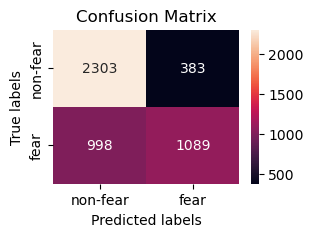

In [55]:
cf = confusion_matrix(y[test_indices_total], y_pred_total, labels = ['nomiedo', 'miedo'])

figure(figsize=(3, 2))
ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['non-fear', 'fear']); ax.yaxis.set_ticklabels(['non-fear', 'fear']);

In [56]:
# testing with training values to check overfitting

y_pred_overfit=clf_rf.predict(x.loc[train_indices_total,:])

acc = accuracy_score(y.loc[train_indices_total], y_pred_overfit)
f1 = f1_score(y.loc[train_indices_total], y_pred_overfit, pos_label = 'miedo')

print('Accuracy is '+ str(acc)) #Accuracy Score
print('F1 is '+ str(f1)) #Accuracy Score std

Accuracy is 0.9425937565472449
F1 is 0.933170731707317


## 6. LOSO split classification

In [58]:
y = features[labels_column]
x = features[data_columns]
gr = features[groups_columns]

print ("dataset : ",features.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)
print ("gr : ",gr.shape)

dataset :  (4773, 157)
x :  (4773, 50)
y :  (4773,)
gr :  (4773,)


In [59]:
# Creating splits
logo = LeaveOneGroupOut()
logo.get_n_splits(x, y, gr)

metrics = np.zeros((logo.get_n_splits(x, y, gr), 2))
conf_matrixes = np.zeros((2,2,logo.get_n_splits(x, y, gr)))

test_indices_total = np.array([])
y_pred_total = np.array([])
train_indices_total = np.array([])

perc_user = pd.DataFrame(columns = ['User', 'Percentage'], index = range(27))


i=0
# Training and Evaluation/prediction
for train_indices, test_indices in logo.split(x, y, gr):
    
    clf_rf.fit(x.loc[train_indices,:], y.loc[train_indices])
    y_pred=clf_rf.predict(x.loc[test_indices,:])

    metrics[i, 0] = accuracy_score(y.loc[test_indices], y_pred)
    metrics[i, 1] = f1_score(y.loc[test_indices], y_pred, pos_label = 'miedo')

    conf_matrixes[:,:,i] = confusion_matrix(y[test_indices], y_pred, labels = ['nomiedo', 'miedo'])


    #Concatenate the predictions:
    test_indices_total = np.append(test_indices_total, test_indices)
    train_indices_total = np.append(train_indices_total, train_indices)
    y_pred_total = np.append(y_pred_total, y_pred)

    #Percentage of right predictions per user
    perc_user['User'][i] = features['Voluntaria'][test_indices[1]]

    tot = len(y_pred)
    right = 0

    for k in range(tot):
        if y_pred[k] == y[test_indices[k]]:
            right = right+1
        perc = (right/tot)*100

    perc_user['Percentage'][i] = perc


    i = i+1

In [60]:
print('Mean Accuracy for 27 users is '+ str(np.mean(metrics[:,0]))) #Accuracy Score
print('Std Accuracy for 27 users is '+ str(np.std(metrics[:,0]))) #Accuracy Score std
print('Mean F1-score for 27 users is '+ str(np.mean(metrics[:,1]))) #F1-score Score
print('Std F1-score for 27 users is '+ str(np.std(metrics[:,1]))) #F1-score Score std

Mean Accuracy for 27 users is 0.5424440494877493
Std Accuracy for 27 users is 0.08726566435252214
Mean F1-score for 27 users is 0.3201601959829997
Std F1-score for 27 users is 0.1375267713254212


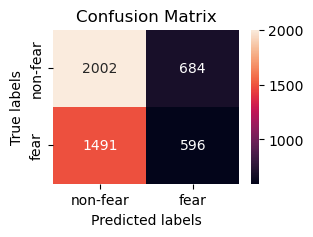

In [61]:
cf = confusion_matrix(y[test_indices_total], y_pred_total, labels = ['nomiedo', 'miedo'])

figure(figsize=(3, 2))
ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['non-fear', 'fear']); ax.yaxis.set_ticklabels(['non-fear', 'fear']);

### Results per user

In [62]:
perc_mean = np.mean(perc_user['Percentage'])
print('The mean right predictions is '+str(perc_mean))
perc_std = np.std(perc_user['Percentage'])
print('The std of the right predictions is '+str(perc_std))
print('The results per user are:')
print(perc_user)

The mean right predictions is 54.24440494877493
The std of the right predictions is 8.726566435252215
The results per user are:
     User Percentage
0   S010G  55.696203
1   S012G       50.0
2   S013G  49.356223
3   S014L  53.475936
4   S015L  55.384615
5   S016L  55.102041
6   S017L  50.490196
7   S018G  66.451613
8   S019G   50.78125
9    S01G  60.106383
10  S020G  62.777778
11  S021L  57.671958
12  S022G  65.641026
13  S023G  44.776119
14  S024G  49.206349
15  S025G  34.586466
16  S026G  55.707763
17  S027G  64.485981
18  S028G  62.430939
19  S029G  49.681529
20   S02G  63.380282
21   S03L   33.68984
22   S04G  45.833333
23   S05L   59.42029
24   S07L  50.877193
25   S08G       48.0
26   S09G  69.587629


## 7. LHSO split classification

### Adding a column which separates both groups

In [63]:
features_LHSO = features.copy()
features_LHSO.insert(1,"half",np.nan)
vid_1 = ["Video1", "Video2", "Video3", "Video4", "Video5", "Video6", "Video10"]
vid_2 = ["Video7", "Video8", "Video9", "Video11", "Video12", "Video13", "Video14"]

for i in range(0, len(features_LHSO.index)):
    if features_LHSO["Video"][i] in vid_1:
        features_LHSO["half"][i] = str(features_LHSO["Voluntaria"][i] + "_1")
    else:
        features_LHSO["half"][i] = str(features_LHSO["Voluntaria"][i] + "_2")
features_LHSO.head(20)

,Voluntaria,half,Video,Miedo/NoMiedo,hjorth_complexity_spect-ch0,hjorth_complexity_spect-ch1,hjorth_complexity_spect-ch2,hjorth_complexity_spect-ch3,hjorth_complexity_spect-ch4,hjorth_complexity_spect-ch5,...,DE-ch4,DE-ch5,DE-ch6,DE-ch7,DE-ch8,DE-ch9,DE-ch10,DE-ch11,DE-ch12,DE-ch13
0,S01G,S01G_2,Video8,nomiedo,0.150725,0.152482,0.189861,0.305989,0.070728,0.068646,...,0.495043,0.558630,0.512318,0.683753,0.501923,0.606046,0.421022,0.641541,0.644123,0.499119
1,S01G,S01G_2,Video8,nomiedo,0.143964,0.155864,0.148793,0.282917,0.100549,0.096555,...,0.568088,0.563330,0.502744,0.517787,0.474887,0.620825,0.395762,0.584332,0.567186,0.376617
2,S01G,S01G_2,Video8,nomiedo,0.092994,0.109914,0.135640,0.224055,0.074237,0.063921,...,0.413851,0.520168,0.479380,0.480177,0.390705,0.590140,0.183514,0.516359,0.520558,0.310193
3,S01G,S01G_2,Video8,nomiedo,0.083058,0.117398,0.139373,0.181389,0.066812,0.061041,...,0.381220,0.472239,0.452526,0.488434,0.368683,0.562231,0.227613,0.533101,0.561889,0.410218
4,S01G,S01G_2,Video8,nomiedo,0.076462,0.094819,0.141432,0.105702,0.076236,0.079977,...,0.470624,0.570559,0.506131,0.583586,0.447007,0.577983,0.192038,0.605817,0.576491,0.371527
5,S01G,S01G_2,Video8,nomiedo,0.083909,0.081853,0.130393,0.096639,0.073373,0.069493,...,0.368856,0.589175,0.527744,0.541886,0.350711,0.543537,0.093452,0.582945,0.514627,0.372712
6,S01G,S01G_2,Video8,nomiedo,0.099373,0.128795,0.153650,0.110093,0.074528,0.064788,...,0.476756,0.528315,0.490899,0.525806,0.390018,0.534888,0.190214,0.603897,0.583720,0.388711
7,S01G,S01G_2,Video8,nomiedo,0.134098,0.158257,0.137203,0.166923,0.073401,0.076729,...,0.433486,0.552435,0.517469,0.619919,0.455374,0.598911,0.269746,0.744294,0.625637,0.609769
8,S01G,S01G_2,Video8,nomiedo,0.088604,0.129017,0.125907,0.074884,0.077008,0.071380,...,0.414815,0.572304,0.482110,0.503185,0.398931,0.453953,0.113797,0.551244,0.491257,0.329184
9,S01G,S01G_2,Video8,nomiedo,0.075531,0.118363,0.139635,0.086589,0.083554,0.086548,...,0.384214,0.574988,0.492468,0.499514,0.453063,0.590886,0.173753,0.570218,0.560247,0.348387


In [64]:
labels_column = 'Miedo/NoMiedo'
groups_columns = 'half'

y = features_LHSO[labels_column]
x = features_LHSO[data_columns]
gr = features_LHSO[groups_columns]

print ("dataset : ",features_LHSO.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)
print ("gr : ",gr.shape)

dataset :  (4773, 158)
x :  (4773, 50)
y :  (4773,)
gr :  (4773,)


In [65]:
# Creating splits
logo = LeaveOneGroupOut()
logo.get_n_splits(x, y, gr)

metrics = np.zeros((logo.get_n_splits(x, y, gr), 2))
conf_matrixes = np.zeros((2,2,logo.get_n_splits(x, y, gr)))

test_indices_total = np.array([])
y_pred_total = np.array([])
train_indices_total = np.array([])

perc_video = pd.DataFrame(columns = ['User', 'Percentage'], index = range(54))

In [66]:
i=0
# Training and Evaluation/prediction
for train_indices, test_indices in logo.split(x, y, gr):
    
    clf_rf = RandomForestClassifier(criterion='gini', max_features='sqrt', n_estimators=500, random_state = 2,
                                   class_weight='balanced_subsample', max_depth = 20)
    clf_rf.fit(x.loc[train_indices,:], y.loc[train_indices])
    y_pred=clf_rf.predict(x.loc[test_indices,:])

    metrics[i, 0] = accuracy_score(y.loc[test_indices], y_pred)
    metrics[i, 1] = f1_score(y.loc[test_indices], y_pred, pos_label = 'miedo')

    conf_matrixes[:,:,i] = confusion_matrix(y[test_indices], y_pred, labels = ['nomiedo', 'miedo'])


    #Concatenate the predictions:
    test_indices_total = np.append(test_indices_total, test_indices)
    train_indices_total = np.append(train_indices_total, train_indices)
    y_pred_total = np.append(y_pred_total, y_pred)

    #Percentage of right predictions per user
    perc_video['User'][i] = features_LHSO['half'][test_indices[1]]

    tot = len(y_pred)
    right = 0

    for k in range(tot):
        if y_pred[k] == y[test_indices[k]]:
            right = right+1
        perc = (right/tot)*100

    perc_video['Percentage'][i] = perc

    i = i+1

In [67]:
print('Mean Accuracy for all 27 x 2 rounds is '+ str(np.mean(metrics[:,0]))) #Accuracy Score
print('Std Accuracy for 27 x 2 rounds is '+ str(np.std(metrics[:,0]))) #Accuracy Score std
print('Mean F1-score for 27 x 2 rounds is '+ str(np.mean(metrics[:,1]))) #F1-score Score
print('Std F1-score for 27 x 2 rounds is '+ str(np.std(metrics[:,1]))) #F1-score Score std

Mean Accuracy for all 27 x 2 rounds is 0.5216013910932138
Std Accuracy for 27 x 2 rounds is 0.11076796924272987
Mean F1-score for 27 x 2 rounds is 0.27443663075058117
Std F1-score for 27 x 2 rounds is 0.1426733537751167


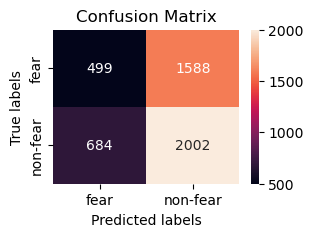

In [70]:
cf = confusion_matrix(y[test_indices_total], y_pred_total, labels = ['miedo', 'nomiedo'])

figure(figsize=(3, 2))
ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fear', 'non-fear']); ax.yaxis.set_ticklabels(['fear', 'non-fear']);

### Results per user and round

In [71]:
perc_mean = np.mean(perc_video['Percentage'])
print('The mean right predictions is '+str(perc_mean))
perc_std = np.std(perc_video['Percentage'])
print('The std of the right predictions is '+str(perc_std))
print('The results per user and round are:')
print(perc_video)

The mean right predictions is 52.16013910932138
The std of the right predictions is 11.076796924272989
The results per user and round are:
       User Percentage
0   S010G_1  58.108108
1   S010G_2  58.333333
2   S012G_1  25.641026
3   S012G_2       47.2
4   S013G_1  43.859649
5   S013G_2  54.621849
6   S014L_1  52.747253
7   S014L_2  54.166667
8   S015L_1  40.944882
9   S015L_2  53.383459
10  S016L_1  52.631579
11  S016L_2  53.465347
12  S017L_1  39.285714
13  S017L_2  58.333333
14  S018G_1  63.291139
15  S018G_2  68.421053
16  S019G_1  47.272727
17  S019G_2   58.90411
18   S01G_1  51.612903
19   S01G_2  65.263158
20  S020G_1  61.764706
21  S020G_2  65.384615
22  S021L_1  52.439024
23  S021L_2  64.485981
24  S022G_1  58.163265
25  S022G_2  44.329897
26  S023G_1  42.857143
27  S023G_2  49.122807
28  S024G_1  46.341463
29  S024G_2  54.205607
30  S025G_1       25.0
31  S025G_2  39.130435
32  S026G_1  54.545455
33  S026G_2   54.12844
34  S027G_1      68.75
35  S027G_2  65.116279
36  S028G_

## 8. LOVO split classification

In [72]:
groups_columns = 'Video'

y = features[labels_column]
x = features[data_columns]
gr = features[groups_columns]

print ("dataset : ",features.shape)
print ("x : ",x.shape)
print ("y : ",y.shape)
print ("gr : ",gr.shape)

dataset :  (4773, 157)
x :  (4773, 50)
y :  (4773,)
gr :  (4773,)


In [73]:
# Creating splits
logo = LeaveOneGroupOut()
logo.get_n_splits(x, y, gr)

metrics = np.zeros((logo.get_n_splits(x, y, gr), 2))
conf_matrixes = np.zeros((2,2,logo.get_n_splits(x, y, gr)))

test_indices_total = np.array([])
y_pred_total = np.array([])
y_pred_proba_total = np.empty((0, 2))
train_indices_total = np.array([])

perc_video = pd.DataFrame(columns = ['Video', 'Percentage'], index = range(14))

In [74]:
i=0
# Training and Evaluation/prediction
for train_indices, test_indices in logo.split(x, y, gr):
    
    clf_rf = RandomForestClassifier(criterion='gini', max_features='sqrt', n_estimators=500, random_state = 2,
                                   class_weight='balanced_subsample', max_depth = 20)
    clf_rf.fit(x.loc[train_indices,:], y.loc[train_indices])
    y_pred=clf_rf.predict(x.loc[test_indices,:])
    y_pred_proba=clf_rf.predict_proba(x.loc[test_indices,:])

    metrics[i, 0] = accuracy_score(y.loc[test_indices], y_pred)
    metrics[i, 1] = f1_score(y.loc[test_indices], y_pred, pos_label = 'miedo')

    conf_matrixes[:,:,i] = confusion_matrix(y[test_indices], y_pred, labels = ['miedo', 'nomiedo'])


    #Concatenate the predictions:
    test_indices_total = np.append(test_indices_total, test_indices)
    train_indices_total = np.append(train_indices_total, train_indices)
    y_pred_total = np.append(y_pred_total, y_pred)
    y_pred_proba_total = np.vstack((y_pred_proba_total, y_pred_proba))

    #Percentage of right predictions per user
    perc_video['Video'][i] = features['Video'][test_indices[1]]

    tot = len(y_pred)
    right = 0

    for k in range(tot):
        if y_pred[k] == y[test_indices[k]]:
            right = right+1
        perc = (right/tot)*100

    perc_video['Percentage'][i] = perc


    i = i+1

In [75]:
print('Mean Accuracy for 14 videos is '+ str(np.mean(metrics[:,0]))) #Accuracy Score
print('Std Accuracy for 14 videos is '+ str(np.std(metrics[:,0]))) #Accuracy Score std
print('Mean F1-score for 14 videos is '+ str(np.mean(metrics[:,1]))) #F1-score Score
print('Std F1-score for 14 videos is '+ str(np.std(metrics[:,1]))) #F1-score Score std

Mean Accuracy for 14 videos is 0.4565021851964965
Std Accuracy for 14 videos is 0.19941680014579125
Mean F1-score for 14 videos is 0.15019808818929617
Std F1-score for 14 videos is 0.11625592917601858


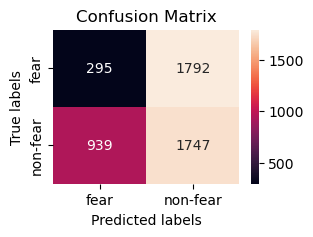

In [76]:
cf = confusion_matrix(y[test_indices_total], y_pred_total, labels = ['miedo', 'nomiedo'])

figure(figsize=(3, 2))
ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fear', 'non-fear']); ax.yaxis.set_ticklabels(['fear', 'non-fear']);

### Results per video

In [77]:
perc_mean = np.mean(perc_video['Percentage'])
print('The mean right predictions is '+str(perc_mean))
perc_std = np.std(perc_video['Percentage'])
print('The std of the right predictions is '+str(perc_std))
print('The results per video are:')
print(perc_video)

The mean right predictions is 45.65021851964966
The std of the right predictions is 19.941680014579124
The results per video are:
      Video Percentage
0    Video1  24.853801
1   Video10   9.725159
2   Video11  70.547945
3   Video12  13.643927
4   Video13  46.391753
5   Video14  24.590164
6    Video2  58.303887
7    Video3  63.190184
8    Video4     31.875
9    Video5  52.970297
10   Video6   66.31016
11   Video7  51.206434
12   Video8  63.862928
13   Video9   61.63142
